This dataset is a collection of attributes of startup companies linked to their dependent variable of success. It can be found at https://www.kaggle.com/datasets/manishkc06/startup-success-prediction, with data provided by Ramkishan Panthena.

In this notebook, rather than dropping key objects, objects will be converted to numeric attributes that are able to be passed into classification models. The 'dummies' function of Pandas will be used for this purpose. One-hot-encoding (OHE) is often used in these cases, but due to the easily interpretable nature of logistic regression, it is more straightforward to use the dummies approach and assess determied coefficients using the added attributes.

Models will be scored by accuracy, F1 score, and ROC AUC. 
* Accuracy is a measure of correctly classified observations.
* F1 score takes both precision and recall into account, and is useful at detecting imbalance in classification.
* ROC AUC measures the true positive rate and false positive rate.

For all three measures, the threshold for 'acceptable' will be set at 0.7, with higher numbers being much more desirable. However, the maximum of these numbers depends greatly on how much predictive power is able to be realistically obtained from the dataset.  

In [10]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('startup_data.csv')
df.head()

,Unnamed: 0,state_code,latitude,longitude,zip_code,id,city,Unnamed: 6,name,labels,...,object_id,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
0,1005,CA,42.358880,-71.056820,92101,c:6669,San Diego,NaN,Bandsintown,1,...,c:6669,0,1,0,0,0,0,1.0000,0,acquired
1,204,CA,37.238916,-121.973718,95032,c:16283,Los Gatos,NaN,TriCipher,1,...,c:16283,1,0,0,1,1,1,4.7500,1,acquired
2,1001,CA,32.901049,-117.192656,92121,c:65620,San Diego,San Diego CA 92121,Plixi,1,...,c:65620,0,0,1,0,0,0,4.0000,1,acquired
3,738,CA,37.320309,-122.050040,95014,c:42668,Cupertino,Cupertino CA 95014,Solidcore Systems,1,...,c:42668,0,0,0,1,1,1,3.3333,1,acquired
4,1002,CA,37.779281,-122.419236,94105,c:65806,San Francisco,San Francisco CA 94105,Inhale Digital,0,...,c:65806,1,1,0,0,0,0,1.0000,1,closed


Many of these values are categorical and cannot be fed into the model. They will be spread into additional attributes via the Pandas 'dummies' function. This converts them into numeric Boolean variables that can be fed into a model.

Redundant attributes (such as multiple location attributes) or irrelevant attributes will be dropped.

Since the target variable is categorical, it will be converted to a numeric Boolean.

In [3]:
loc_to_drop = ['latitude', 'longitude', 'zip_code', 'city', 'state_code.1', 'is_CA', 'is_NY', 'is_MA', 'is_TX', 
               'is_otherstate']
cat_to_drop = ['is_software', 'is_web', 'is_mobile', 'is_enterprise', 'is_advertising', 'is_gamesvideo', 'is_ecommerce',
              'is_biotech', 'is_consulting', 'is_othercategory']
extras_to_drop = ['Unnamed: 0', 'id', 'Unnamed: 6', 'name', 'labels', 'closed_at', 'last_funding_at', 'age_last_funding_year', 
                  'age_first_milestone_year', 'age_last_milestone_year', 'object_id']

df.drop(loc_to_drop, axis=1, inplace=True)
df.drop(cat_to_drop, axis=1, inplace=True)
df.drop(extras_to_drop, axis=1, inplace=True)

df['founded_at'] = df['founded_at'].str.slice(start=-4, stop=None)
df['first_funding_at'] = df['first_funding_at'].str.slice(start=-4, stop=None)

objects = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=objects)

df.drop('status_closed', axis=1, inplace=True)

print(df.shape)
df.head()

(923, 121)


,age_first_funding_year,relationships,funding_rounds,funding_total_usd,milestones,has_VC,has_angel,has_roundA,has_roundB,has_roundC,...,category_code_search,category_code_security,category_code_semiconductor,category_code_social,category_code_software,category_code_sports,category_code_transportation,category_code_travel,category_code_web,status_acquired
0,2.2493,3,3,375000,3,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,5.1260,9,4,40100000,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
2,1.0329,5,1,2600000,2,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
3,3.1315,5,3,40000000,1,0,0,0,1,1,...,0,0,0,0,1,0,0,0,0,1
4,0.0000,2,2,1300000,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Splitting the dataset into independent and dependent subsets. 
X, y = df.iloc[:,:-1], df.iloc[:, -1:]
y = y.values.reshape(923,)
print(X.shape)
print(y.shape)

(923, 120)
(923,)


Below, a logistic regression function that utilizes an L1 pentalty is implemented. 

In [5]:
# Implementation and testing of a logistic regression model using a l1 function. 
mod = LogisticRegression(penalty='l1', solver='liblinear')
# Performing cross-validation
scores = cv_results = cross_validate(mod, X, y, cv=5, scoring=('accuracy', 'f1', 'roc_auc'), return_train_score=True)
test_accuracy = np.mean(scores['test_accuracy'])
test_f1 = np.mean(scores['test_f1'])
test_roc = np.mean(scores['test_roc_auc'])
print(f'Test accuracy: {test_accuracy}\nTest F1 score: {test_f1}\nTest ROC AUC: {test_roc}')

Test accuracy: 0.7606345475910693
Test F1 score: 0.822325589181772
Test ROC AUC: 0.8093124914301384


A k = 5 k-folds cross validation was run on the data, with test accuracy, F1 score, and ROC AUC measured and displayed. The measures obtained are roughly similar to the non-dummies approach, but the real value of this method lies in the greater range of attributes available in assessing critical attribute coefficients. 

In [8]:
# Fitting the model to obtain coefficients
mod.fit(X, y)
coeffs = mod.coef_[0]

# Creating a dictionary of attributes to coefficients 
attr_coeffs = {}
attrs = df.columns
for i in range(len(coeffs)):
    attr_coeffs[attrs[i]] = coeffs[i]
attr_coeffs = dict(sorted(attr_coeffs.items(), key=lambda item: item[1], reverse=True))
attr_coeffs

{'founded_at_2002': 1.33563812988776,
 'founded_at_2000': 1.317163925348523,
 'founded_at_2001': 0.9823428603312943,
 'state_code_OR': 0.9250657945160204,
 'is_top500': 0.8794241023259388,
 'founded_at_2003': 0.7726629909396865,
 'state_code_TN': 0.7653914809239578,
 'state_code_CO': 0.7523652649979655,
 'state_code_MA': 0.6485816261073539,
 'category_code_analytics': 0.6271474402332263,
 'category_code_biotech': 0.47415441090433574,
 'milestones': 0.39633511042947894,
 'first_funding_at_2012': 0.39469435405397674,
 'category_code_travel': 0.3855451278301791,
 'state_code_NY': 0.3853335463558374,
 'category_code_semiconductor': 0.2760544345847568,
 'category_code_enterprise': 0.25481710902995114,
 'category_code_security': 0.23798112398431462,
 'founded_at_2009': 0.2379805244348602,
 'state_code_CA': 0.2166288333244712,
 'founded_at_2004': 0.21013629039288745,
 'relationships': 0.14666390790179515,
 'category_code_music': 0.1332296603998987,
 'has_roundD': 0.12948448223458645,
 'has_ro

Text(0, 0.5, 'Coefficient')

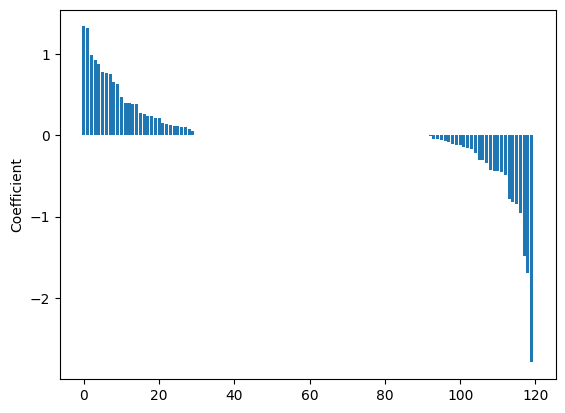

In [12]:
# Creating a range to plot coefficients against. 
attrs_plot = range(len(attr_coeffs))
coeffs_plot = attr_coeffs.values()

plt.bar(attrs_plot, coeffs_plot)
plt.ylabel('Coefficient')

In summary, using the dummies function allowed not only for more granularity in categories and states, but also allowed for involvement of years of founding and initial funding. This is significant because interestingly enough, some of the most significant parameters involve founding dates. A company founded in the early 2000s is a strong predictor of success, whereas being founded just prior to 2000 is a strong predictor of failure. The performance between the non-dummies model and the dummies model were very similar.

A look at the bar chart of the calcualted coefficients shows that roughly half of the features were dropped, as they did not positively contribute to the model. Also notable is that the magnitude of negative coefficients reached much higher peaks than the positive ones, the opposite of what was observed without the dummies. 